# **Faker News Classifier Using LSTM**

In [1]:
# Importing Librareis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [2]:
# loading dataset
df = pd.read_csv("Datasets/Fake News Classifier.csv")

In [3]:
# display first five records of the dataset
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
# checking null values
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [5]:
# dropping null values
df.dropna(inplace = True)

In [6]:
# reseting the index after droping some null values
df.reset_index(inplace=True)

In [7]:
df.head(2)

,index,id,title,author,text,label
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0


In [8]:
# splitting the dataset into feature matrix and target vector
X = df.drop("label", axis = 1)
y = df.label

In [9]:
X.head(2)

,index,id,title,author,text
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...


In [10]:
# checking the len of the feature matrix
len(X)

18285

In [11]:
# Creating Stemmer object
stemmer = PorterStemmer()

In [12]:
# list to store
corpus = []
for row in range(len(X)):
    row = X["title"][row]    # Getting the row
    row = re.sub("[^a-zA-Z]", " ", row)   # keep only the alphabet characters
    row = row.lower()  # lowering the sentence
    words = row.split()  # splitting the sentence into words
    words = [stemmer.stem(word) for word in words if word not in stopwords.words("english")]  # removing unnecessary characters and apply stemming
    sentence = ' '.join(words)  # remaking sentence again from words
    corpus.append(sentence) # appending the sentence to the corpus

In [13]:
corpus[0:8]

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth might get fire',
 'civilian kill singl us airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri',
 'jacki mason hollywood would love trump bomb north korea lack tran bathroom exclus video breitbart',
 'beno hamon win french socialist parti presidenti nomin new york time',
 'back channel plan ukrain russia courtesi trump associ new york time']

## **Encoding using keras one_hot encoder**
Args:
* **input_text**: Input text (string).
* **n**: int. Size of vocabulary.
* **filters**: list (or concatenation) of characters to filter out, such as
* **punctuation**. Default:
      ```
      '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n
      ```,
      includes basic punctuation, tabs, and newlines.
* **lower**: boolean. Whether to set the text to lowercase.
* **split**: str. Separator for word splitting.

In [14]:
from tensorflow.keras.preprocessing.text import one_hot

In [15]:
#Size of vocabulary.
vocab = 10000 
encodedCorpus = [one_hot(doc, vocab) for doc in corpus]

In [16]:
encodedCorpus[0:5]

[[1952, 3095, 3747, 3130, 8259, 8401, 7227, 801, 7295, 8771],
 [8686, 2003, 3942, 7309, 5197, 8698, 4738],
 [6482, 6421, 8995, 8023],
 [2947, 8997, 9519, 5577, 4544, 2124],
 [396, 5197, 4593, 6505, 4504, 4956, 5197, 8322, 9655, 6372]]

In [17]:
# finding the max length of sentence inside the corpus
maxSentLen = 0
for i in encodedCorpus:
    sentLen = len(i)
    if maxSentLen < sentLen:
        maxSentLen = sentLen

# printing maxlen
maxSentLen

47

## **Converting all the sequenceses into equal length** 
Args:
* **sequences**: List of sequences (each sequence is a list of integers).
* **maxlen**: Optional Int, maximum length of all sequences. If not provided,
        sequences will be padded to the length of the longest individual
        sequence.
* dtype: (Optional, defaults to int32). Type of the output sequences.
        To pad sequences with variable length strings, you can use `object`.
* padding: String, 'pre' or 'post' (optional, defaults to 'pre'):
        pad either before or after each sequence.
* truncating: String, 'pre' or 'post' (optional, defaults to 'pre'):
        remove values from sequences larger than
        `maxlen`, either at the beginning or at the end of the sequences.
* value: Float or String, padding value. (Optional, defaults to 0.)

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [19]:
equalLenSequenced = pad_sequences(encodedCorpus, maxlen = maxSentLen, )
equalLenSequenced

array([[   0,    0,    0, ...,  801, 7295, 8771],
       [   0,    0,    0, ..., 5197, 8698, 4738],
       [   0,    0,    0, ..., 6421, 8995, 8023],
       ...,
       [   0,    0,    0, ..., 7262,  601, 2576],
       [   0,    0,    0, ..., 2219, 9582, 9661],
       [   0,    0,    0, ..., 8994,   69,  547]], dtype=int32)

## **Creating model architecture**
Embedding layer args
Args:
* input_dim: Integer. Size of the vocabulary,
    i.e. maximum integer index + 1.
* output_dim: Integer. Dimension of the dense embedding.
* embeddings_initializer: Initializer for the `embeddings`
    matrix (see `keras.initializers`).
* embeddings_regularizer: Regularizer function applied to
    the `embeddings` matrix (see `keras.regularizers`).
* embeddings_constraint: Constraint function applied to
    the `embeddings` matrix (see `keras.constraints`).
* mask_zero: Boolean, whether or not the input value 0 is a special "padding"
    value that should be masked out.
    This is useful when using recurrent layers
    which may take variable length input.
    If this is `True`, then all subsequent layers
    in the model need to support masking or an exception will be raised.
    If mask_zero is set to True, as a consequence, index 0 cannot be
    used in the vocabulary (input_dim should equal size of
    vocabulary + 1).
* input_length: Length of input sequences, when it is constant.
    This argument is required if you are going to connect
    `Flatten` then `Dense` layers upstream
    (without it, the shape of the dense outputs cannot be computed).

* Input shape:
  2D tensor with shape: `(batch_size, input_length)`.

* Output shape:
  3D tensor with shape: `(batch_size, input_length, output_dim)`.

In [20]:
# importing librares 
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, BatchNormalization
from tensorflow.keras.models import Sequential

In [21]:
# input_dim: Size of the vocabulary
# output_dim: Dimension of the dense embedding. len of features

model = Sequential()
model.add(Embedding(input_dim = vocab, output_dim = 100, input_length = maxSentLen))
model.add(Dropout(0.2))
model.add(LSTM(units = 100))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

2022-11-27 12:44:49.154006: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 12:44:49.163775: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 100)           1000000   
                                                                 
 dropout (Dropout)           (None, 47, 100)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                        

## **compiling our Model**

In [23]:
model.compile(optimizer="adam", loss = "binary_crossentropy", metrics = ["accuracy"])

## **Splitting the dataset into training and testing splits**

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
XTrain, XTest, ytrain, ytest = train_test_split(equalLenSequenced, y, random_state=0, test_size=0.3)

## **Model training**

In [26]:
history = model.fit(XTrain, ytrain, epochs=10, validation_data=(XTest, ytest))

Epoch 1/10
400/400 [==============================] - 127s 303ms/step - loss: 0.2354 - accuracy: 0.9049 - val_loss: 0.4045 - val_accuracy: 0.7687
Epoch 2/10
400/400 [==============================] - 91s 228ms/step - loss: 0.1122 - accuracy: 0.9575 - val_loss: 0.2106 - val_accuracy: 0.9249
Epoch 3/10
400/400 [==============================] - 64s 161ms/step - loss: 0.0611 - accuracy: 0.9774 - val_loss: 0.2488 - val_accuracy: 0.9141
Epoch 4/10
400/400 [==============================] - 45s 114ms/step - loss: 0.0409 - accuracy: 0.9855 - val_loss: 0.3196 - val_accuracy: 0.9101
Epoch 5/10
400/400 [==============================] - 47s 118ms/step - loss: 0.0335 - accuracy: 0.9891 - val_loss: 0.3425 - val_accuracy: 0.9180
Epoch 6/10
400/400 [==============================] - 47s 118ms/step - loss: 0.0267 - accuracy: 0.9911 - val_loss: 0.3522 - val_accuracy: 0.9185
Epoch 7/10
400/400 [==============================] - 47s 118ms/step - loss: 0.0217 - accuracy: 0.9934 - val_loss: 0.4157 - val_a

## **Evalutaion**

In [27]:
model.evaluate(XTest, ytest)

172/172 [==============================] - 5s 28ms/step - loss: 0.5391 - accuracy: 0.9121


[0.5391464829444885, 0.9121400117874146]

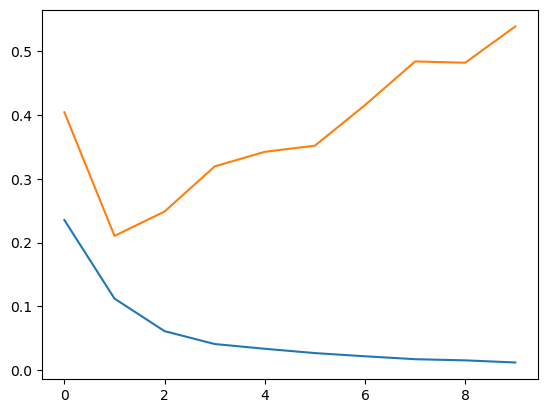

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

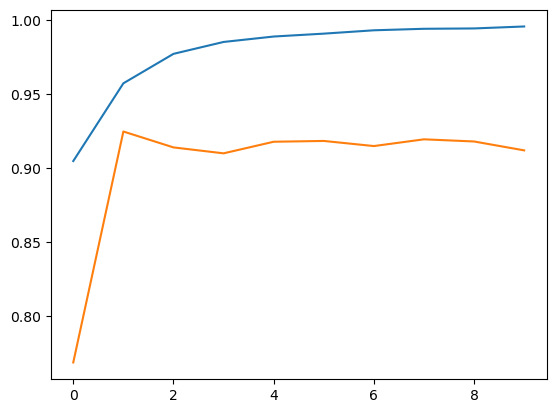

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

It's going to overfit, we can do some hyperparameter tuning so that it did not overfit